Preberi podatke iz datoteke 'vaje1a_train.csv' s pomočjo knjižnjice pandas.

In [1]:
# Okrajšamo ime pandas
import pandas as pd

In [2]:
# Preberemo csv z metodo pandas.read_csv. Ta nam tabelo pretvori v DataFrame objekt (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html)
train_set = pd.read_csv("../Podatki/vaje1a_train.csv")
# Izpišemo prvih nekaj vrstic z metodo DataFrame.head()
train_set.head()

,Height,Weight,Sex
0,1.822293,57.729028,Male
1,1.782341,112.787042,Male
2,1.836338,87.666535,Male
3,1.634066,58.728574,Male
4,1.719421,85.021465,Male


Vizualiziraj podatke s pomočjo knjižnjic matplotlib in seaborn

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

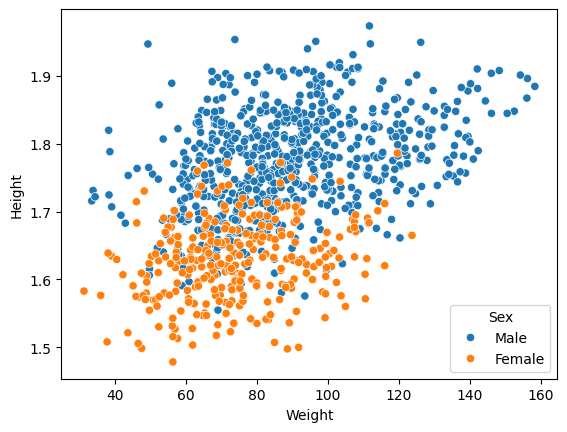

In [6]:
# Scatterplot (obstaja v matplotlibu in seabornu) vsako vrstico prikaže neodvisno, kot točko na grafu
sns.scatterplot(train_set, x="Weight", y="Height", hue="Sex")
plt.show()

Loči podatke na napovedne spremenljivko (x) in ciljno spremenljivko (y) ter jih pretvori v numpy array

In [7]:
# Izberemo vsa imena stolpcev razen stolpca "Sex"
all_variable_names = train_set.columns.drop(["Sex"])
# Izberemo le podmnožico stolpcev v tabeli
x_train = train_set[all_variable_names]
# DataFrame pretvorimo v numpy.array
x_train = x_train.to_numpy()

# Izberemo le stolpec "Sex" in ga pretvorimo v tip "categorical"
y_train = train_set["Sex"].astype("category")
y_train = y_train.to_numpy()

In [8]:
# Preverimo koliko stolpcev vsebuje ciljno vrednost "Male" in koliko "Female"
# Vrednosti v y_train primerjamo z vrednostjo "Male", da dobimo vektor z vrednostmi "True" (1) in "False" (0). z array.sum nato te 1ke seštejemo.
num_male = (y_train == "Male").sum()
# Podobno preštejemo še število vrstic s cilno vrednostjo "Female"
num_female = (y_train == "Female").sum()
print(f'Number of examples labled "Male": {num_male}')
print(f'Number of examples labled "Female": {num_female}')

Number of examples labled "Male": 700
Number of examples labled "Female": 300


Preberi testne podatke, ter jih pretvori v numpy array

In [9]:
# Podobno kot zgoraj
test = pd.read_csv("../Podatki/vaje1a_test.csv")
x_test = test[test.columns.drop(["Sex"])]
x_test = x_test.to_numpy()

y_test = test["Sex"].astype("category")
y_test = y_test.to_numpy()

## Napovedovanje diskretnih spremenljivk (klasifikacija)

Izmisli si nekaj preprostih napovednih modelov in preizkusi njihovo točnost (accuracy) na učnih in testnih podatkih

In [10]:
import numpy as np

Če predpostavimo, da imata učna in testna množica isto porazdelitev ciljne spremenljivke, lahko približno 70% primerov zadanemo že, če zmeraj napovemo "Male" 

In [11]:
# Majority classifier: Poišči najbolj pogosto ciljno vrednost v učnih podatkih in jo uporabi kot napoved za vsak primer iz testne množice
def majority_class(x_train, y_train, x_test):
    # Pripravimo spremenljivki v katerih bomo shranili najbolj pogosto vrednost in število njenih pojavitev
    most_common_class = ""
    occurances = -1
    # Gremo čez vse unikatne vrednosti v y_train in preštejemo, kolikokrat se vsaka vrednost pojavi
    for cls in np.unique(y_train):
        # Vrednost v y_train primerjamo z cls (dobimo vektor z vrednostmi 0 in 1) ter seštejemo
        cls_occurances = (y_train == cls).sum()
        # Če se je trenutna vrednost do sedaj največkrat pojavila, njo in število pojavitev shranimo v ustrezni spremenljivki
        if cls_occurances > occurances:
            occurances = cls_occurances
            most_common_class = cls

    # Najpogostejšo vrednost napovemo tolikokrat, kolikor je vrstic v testni množici (x_test.shape[0])
    y_pred = []
    for x in range(x_test.shape[0]):
        y_pred.append(most_common_class)

    # List pretvorimo v numpy.array
    return np.array(y_pred)

In [12]:
# Naredimo napovedi z napovednim modelom, ki napove najbolj pogost razred
y_pred = majority_class(x_train, y_train, x_test)

# Izračunamo koliko ciljnih vrednosti smo zadeli
print(f"Correctly predicted {(y_pred == y_test).sum()}/{y_test.shape[0]}")

Correctly predicted 700/1000


Opazimo, da je center ciljnih vrednosti "Male" višje in bolj desno kot center ciljnih vrednosti "Female" na grafu. Sestavimo torej napovedni model, ki bo vrstici določil vrednost, glede na to, kateri center je najbližji.

In [13]:
# Clossest mean: Poišči povprečno vrednost za vsako ciljno vrednost. Ciljno vrednost za vrstico iz teste množice določi kot ciljno vrednost, katere povprečna vrednost je najbližje
def clossest_mean(x_train, y_train, x_test):
    # Pripravimo seznam unikatnih vrednosti v y_train
    unique_classes = np.unique(y_train)
    # Pripravimo seznam v katerega bomo shranili povprečne vrednosti
    class_mean = []
    for cls in unique_classes:
        # Izračunamo masko (https://stackoverflow.com/questions/66836922/python-filter-numpy-array-based-on-mask-array), s katero bomo izbrali vrstice iz x_train, ki imajo ciljno vrednost "cls"
        row_mask = y_train == cls
        # Izberemo vrstice, ki imajo ciljno vrednost enako "cls"
        class_instances = x_train[row_mask, :]
        # Z numpy.mean izračunamo povprečno vrednost vrstic (vrednosti na 0-ti osi). Rezultat je np.array z k povprečnimi vrednostmi, kjer je k število stolpcev
        class_mean.append(np.mean(class_instances, axis=0))

    # Pripravimo matriko, v katero bomo shranili razdaljo med vrsticami iz x_test in posamezno ciljno spremenljivko
    # Matrika je velikosti število vrstic v x_test (x_test.shape[0]) X število unikatnih ciljnih vrednosti
    distances = np.zeros((x_test.shape[0], unique_classes.shape[0]))
    for i in range(unique_classes.shape[0]):
        # Vektorsko izračunamo razdaljo vseh vrstic v x_test do centra i-te unikatne ciljne vrednosti (class_mean[i]), z dvopičje naslovimo vse vrednosti na j-ti osi (v našem primeru 0ti) 
        # Razdaljo do centra zračunamo kot mean((x-y)^2) (MSE)
        distances[:, i] = np.mean(np.square(x_test - class_mean[i]), axis=1)

    # Najdemo indeks najbližje razdalje do centra za vsako vrstico
    min_distance_index = distances.argmin(axis=1)
    # Glede na indekse izberemo ustrezno napoved
    return np.array([unique_classes[i] for i in min_distance_index])

In [14]:
# Naredimo napoved glede na najbližji center ciljnih vrednosti in izpišemo število pravilnih napovedi
y_pred = clossest_mean(x_train, y_train, x_test)
print(f"Correctly predicted {(y_pred == y_test).sum()}/{y_test.shape[0]}")

Correctly predicted 589/1000


Opazimo, da imata spremenljivki višina in teža različno zalogo vrednosti in da bo zato teža bolj vplivala na napoved kot višina. To popravimo z normalizacijo (Zalogo vrednosti pretvorimo na interval med 0 in 1).

In [15]:
def clossest_mean2(x_train, y_train, x_test):
    # Normalizacija
    # Najdemo maksimalno vrednost (najnižja možna vemo da je 0)
    # Z axis=0 poskrbimo, da dobimo maksimalno vrednost za vsak stolpec posebaj
    max_values = np.max(x_train, axis=0)
    # x_train in x_test delimo z maksimalno vrednostjo in jih tako normaliziramo
    x_train = x_train / max_values
    x_test = x_test / max_values

    # Ostalo se glede na prejšnji napovedni model ne spremeni
    unique_classes = np.unique(y_train)
    class_mean = []
    for cls in unique_classes:
        class_instances = x_train[y_train == cls, :]
        class_mean.append(np.mean(class_instances, axis=0))

    distances = np.zeros((x_test.shape[0], unique_classes.shape[0]))
    for i in range(unique_classes.shape[0]):
        distances[:, i] = np.mean(np.square(x_test - class_mean[i]), axis=1)

    min_distance_index = distances.argmin(axis=1)
    return np.array([unique_classes[i] for i in min_distance_index])

In [16]:
y_pred = clossest_mean2(x_train, y_train, x_test)
print(f"Correctly predicted {(y_pred == y_test).sum()}/{y_test.shape[0]}")

Correctly predicted 656/1000


Vidimo, da z normalizacijo dobimo boljši rezultat.

Opazimo še, da v tabeli ciljno spremenljivko ločimo večinoma glede na višino. Zato poskusimo spol napovedati le s spremenljivko višina.

In [17]:
y_pred = clossest_mean2(x_train[:, :1], y_train, x_test[:, :1])
print(f"Correctly predicted {(y_pred == y_test).sum()}/{y_test.shape[0]}")

Correctly predicted 859/1000


Preizkusi točnost (accuracy) modela najbližnjih sosedov (nearest neighbour) za različne vrednosti parametra k (k=1, ..., 50)

In [18]:
# Naložimo napovedni model najbližjih sosedov za klasifikacijo.
# sklearn lahko naložimo s pomočjo ukaza "pip install -U scikit-learn"
from sklearn.neighbors import KNeighborsClassifier

In [19]:
# Pripravimo sezname v kater bomo shranjevali točnosti za posamezno podatkovno množico in vrednost parametra k
accuracy_train = []
accuracy_test = []
number_of_neighbours = []

# Gremo čez željene vrednosti za parameter k
for i in range(1, 50):
  number_of_neighbours.append(i)

  # Pripravimo napovedni model z ustreznim parametrom za število sosedov in ga naučimo s pomočjo metode fit, ki sprejme učne podatke in ciljno spremenljivko učnih podatkov
  nbrs = KNeighborsClassifier(n_neighbors=i).fit(x_train, y_train)
  # Napovemo ciljne vrednosti za podatke iz učne množice
  y_pred = nbrs.predict(x_train)
  # Zračunamo točnost naše napovedi na učnih podatkih
  accuracy_train.append((y_pred == y_train).sum())
  # Napovemo ciljne vrednosti za podatke iz testne množice
  y_pred = nbrs.predict(x_test)
  # Zračunamo točnost naše napovedi na testnih podatkih
  accuracy_test.append((y_pred == y_test).sum())

Vizualiziraj točnost modela najbližjih sosedov za različne vrednosti parametra k

<Axes: >

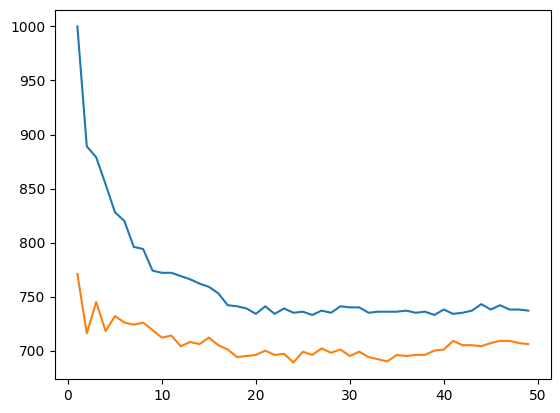

In [20]:
# Točnosti za podatke na učni in testni množici vizuliziramo s pomočjo knjižnice seaborn
sns.lineplot(x=number_of_neighbours, y=accuracy_train)
sns.lineplot(x=number_of_neighbours, y=accuracy_test)
# Modra krivulja predstavlja učne, oranžna pa testne podatke

Vidimo lahko da točnost na učni množici pada, točnost na testni množici pa najprej pada od 33 naprej pa (počasi) narašča

## Napovedovanje numeričnih spremenljivk (regresija)

Preberi podatke iz datoteke 'vaje1b_train.csv' s pomočjo knjižnjice pandas.

In [21]:
train = pd.read_csv("../Podatki/vaje1b_train.csv")
train.head()
train.describe()

,Height,Weight
count,1000.000000,1000.000000
mean,1.697300,67.822722
std,0.064675,7.775650
min,1.501869,46.838635
25%,1.654784,62.311764
50%,1.696841,67.301355
75%,1.742215,73.158016
max,1.883927,100.542996


Vizualiziraj podatke s pomočjo knjižnjic matplotlib ali seaborn

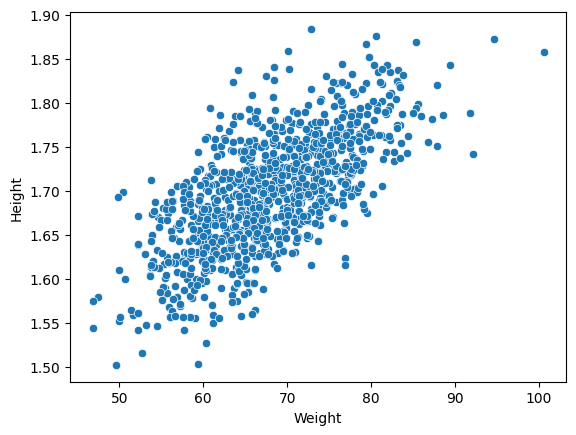

In [22]:
sns.scatterplot(train, x="Weight", y="Height")
plt.show()

Loči podatke na napovedne spremenljivko (x) in ciljno spremenljivko (y) ter jih pretvori v numpy array

In [23]:
# Učne podatke pretvorimo v numpy.array
train = train.to_numpy()
# Da x_train ostane 2D array, drugi stolpec (zadnji) naslovimo kot drugi stolpec in vsi ostali do konca, v nasprotnem primeru dobimo 1D array
x_train = train[:, 1:]
y_train = train[:, 0]

Preberi testne podatke, ter jih pretvori v numpy array

In [24]:
# Preberemo testne podatke in jih pretvorimo v numpy.array
test = pd.read_csv("../Podatki/vaje1b_test.csv")
test = test.to_numpy()
x_test = test[:, 1:]
y_test = test[:, 0]

Izmisli si preprost napovedni model in preizkusi njihovo točnost na učnih in testnih podatkih

In [25]:
# Poišči povprečno vrednost v y_train in jo napoved za vsako vrstico iz x_test
def mean_classifier(x_train, y_train, x_test):
    # Najdemo povprečno vrednost v y_train
    mean_y = y_train.mean()
    # Sestavimo vektor ničel in mu prištejemo povprečno vrednost
    y_pred = np.zeros(x_test.shape[0]) + mean_y
    return y_pred

In [26]:
# Napovej višino z uporabo pristopa mean_classifier
y_pred = mean_classifier(x_train, y_train, x_test)
# Izpiši napako kot povprečno absolutno razliko med napovedmi in pravilnimi vrednostmi mean(|y_pred-y_true|)
print(f"Average error {np.mean(np.abs(y_test-y_pred))}")

Average error 0.049665061596007434


Preizkusi model najbližjih sosedov (nearest neighbour) za različne vrednosti parametra k (k=1, ..., 50)

In [27]:
# Ker sedaj napovedujemo numberično spremenljivko, moramo uporabiti regresijski napovedni model
from sklearn.neighbors import KNeighborsRegressor

In [28]:
# Podobno kot prej, a sedaj z modelom za regresijo
accuracy_train = []
accuracy_test = []
number_of_neighbours = []

for i in range(1, 50):
  number_of_neighbours.append(i)

  nbrs = KNeighborsRegressor(n_neighbors=i).fit(x_train, y_train)
  y_pred = nbrs.predict(x_train)
  accuracy_train.append(np.mean(np.abs(y_train-y_pred)))
  y_pred = nbrs.predict(x_test)
  accuracy_test.append(np.mean(np.abs(y_test-y_pred)))

Vizualiziraj točnost modela najbližjih sosedov za različne vrednosti parametra k

<Axes: >

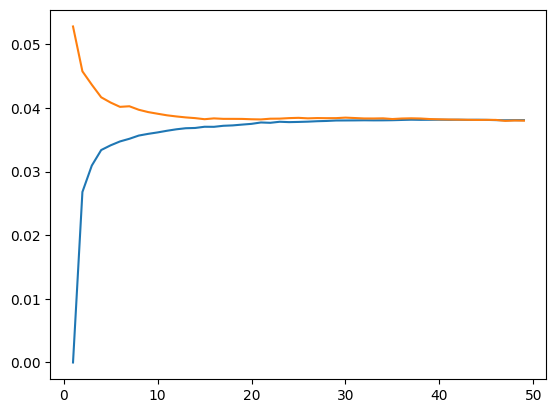

In [29]:
sns.lineplot(x=number_of_neighbours, y=accuracy_train)
sns.lineplot(x=number_of_neighbours, y=accuracy_test)

Vidimo da z večanjem parametra k napaka na učni množici narašča, na testni pa pada. Že pri majhnem k-ju dobimo na testni množici boljši rezultat kot z uporabo pristopa mean_classifier. Pri parametru k=10, se napovedni model v povprečju zmoti za 4 cm.